# 3 Sampling the Imaginary


Lots of books on Bayesian statistics introduce posterior inference by using a medical testing scenario. To repeat the structure of common examples, suppose there is a blood test that correctly detects vampirism 95% of the time. In more precise and mathematical notation, $Pr(positive test result|vampire) = 0.95$. It’s a very accurate test, nearly always catching real vampires. It also make mistakes, though, in the form of false positives. One percent of the time, it incorrectly diagnoses normal people as vampires, $Pr(positive test result|mortal) = 0.01$. The final bit of information we are told is that vampires are rather rare, being only 0.1% of the population, implying $Pr(vampire) = 0.001$. Suppose now that someone tests positive for vampirism. What’s the probability that he or she is a bloodsucking immortal? 

The correct approach is just to use Bayes’ theorem to invert the probability, to compute $Pr(vampire|positive)$. The calculation can be presented as:
$$
Pr(vampire|positive) = \frac{Pr(positive|vampire)Pr(vampire)}{Pr(positive)} 
$$
where $Pr(positive)$ is the average probability of a positive test result, that is, 
$$Pr(positive) = Pr(positive|vampire) Pr(vampire) \\+ Pr(positive|mortal) (1 − Pr(vampire))$$

Performing the calculation in Python: 

In [1]:
# first define the beyes' theorem in function 
def bayes_theorem_binary(p_event:float, p_postive_event:float, p_positive_non_event:float)->float:
    '''
    Baye's theorem function when condition is binary
    ```math 
    P(event|positive) = \frac{P(positive|event)P(event)}{P(positive|event)P(event) + P(positive|not event)P(not event)}
    ``` 
    Args:
        p_event: float, P(event)
        p_postive_event: float, P(positive|event)
        p_positive_non_event: float, P(positive|not event)
    
    Return:
        float
    '''
    p_positive = p_postive_event * p_event + p_positive_non_event * (1-p_event)
    p_event_cond_on_positive = (p_postive_event * p_event)/p_positive

    return p_event_cond_on_positive

In [3]:
pr_positive_vampire = .95  # given blood test to be positive, probability of a vampire
pr_positive_mortal = .01   # given blood test to be positive, probability of a mortal
pr_vampire = .001          # in general, probability of a vampire

bayes_theorem_binary(pr_vampire, pr_positive_vampire, pr_positive_mortal)

0.08683729433272395

**A frequency format or natural frequencies description**  
But I don’t like these examples, for two reasons. First, there’s nothing uniquely “Bayesian” about them. Remember: __Bayesian inference is distinguished by a broad view of probability, not by the use of Bayes’ theorem__. Since all of the probabilities I provided above reference frequencies of events, rather than theoretical parameters, all major statistical philosophies would agree to use Bayes’ theorem in this case. Second, and more important to our work in this chapter, these examples make Bayesian inference seem much harder than it has to be. Few people find it easy to remember which number goes where, probably because they never grasp the logic of the procedure. It’s just a formula that descends from the sky. If you are confused, it is only because you are trying to understand. 

There is a way to present the same problem that does make it more intuitive, however. Suppose that instead of reporting probabilities, as before, I tell you the following: 

-   (1) In a population of 100,000 people, 100 of them are vampires.   
-   (2) Of the 100 who are vampires, 95 of them will test positive for vampirism.  
-   (3) Of the 99,900 mortals, 999 of them will test positive for vampirism. 

Now tell me, if we test all 100,000 people, what proportion of those who test positive for vampirism actually are vampires? Many people, although certainly not all people, find this presentation a lot easier.50 Now we can just count up the number of people who test positive: 95 + 999 = 1094. Out of these 1094 positive tests, 95 of them are real vampires, so that implies: $Pr(vampire|positive) = \frac{95}{1094} ≈ 0.087$ It’s exactly the same answer as before, but without a seemingly arbitrary rule.

## 3.1 Sampling from a grid-approximate posterior
Before beginning to work with samples, we need to generate them. Here’s a reminder for how to compute the posterior for the globe tossing model, using grid approximation. Remember, the posterior here means the probability of $p$ conditional on the data.

In [32]:

from functools import reduce

def factorial(x):
    return reduce(lambda x,y: x*y, [i for i in range(1,x+1)])

class Binominal:
    def __init__(self, prob: float= None, trails: int = None):
        self.prob = prob
        self.trails = trails
        pass

    def probability(self, x):
        p = factorial(self.trails)/(factorial(self.trails-x)*factorial(x))
        p *= (self.prob**x * (1-self.prob)**(self.trails - x))

        return p

0.1640625

In [120]:
Binominal(p_grid,9).probability(6)

array([8.37482519e-17, 5.34380847e-15, 6.06865277e-14, 3.39951725e-13,
       1.29291077e-12, 3.84898254e-12, 9.67643250e-12, 2.14958303e-11,
       4.34465510e-11, 8.15051160e-11, 1.43954177e-10, 2.41900962e-10,
       3.89844003e-10, 6.06286984e-10, 9.14398557e-10, 1.34271697e-09,
       1.92589838e-09, 2.70550774e-09, 3.73085108e-09, 5.05984819e-09,
       6.75994449e-09, 8.90906106e-09, 1.15965817e-08, 1.49243763e-08,
       1.90078583e-08, 2.39770774e-08, 2.99778438e-08, 3.71728851e-08,
       4.57430336e-08, 5.58884438e-08, 6.78298381e-08, 8.18097806e-08,
       9.80939782e-08, 1.16972607e-07, 1.38761662e-07, 1.63804336e-07,
       1.92472413e-07, 2.25167695e-07, 2.62323435e-07, 3.04405807e-07,
       3.51915380e-07, 4.05388622e-07, 4.65399415e-07, 5.32560586e-07,
       6.07525461e-07, 6.90989424e-07, 7.83691499e-07, 8.86415937e-07,
       9.99993822e-07, 1.12530469e-06, 1.26327814e-06, 1.41489548e-06,
       1.58119139e-06, 1.76325553e-06, 1.96223423e-06, 2.17933218e-06,
      

In [121]:
import numpy as np 
p_grid = np.array(range(1, 1000+1))/1000
prob_p = np.ones(1000)

prob_data = Binominal(p_grid,9).probability(6)
posterior = prob_data * prob_p 
posterior = posterior/posterior.sum()

print(f"prob_data, {prob_data[:10]}")
print(f"posterior, {posterior[:10]}")

prob_data, [8.37482519e-17 5.34380847e-15 6.06865277e-14 3.39951725e-13
 1.29291077e-12 3.84898254e-12 9.67643250e-12 2.14958303e-11
 4.34465510e-11 8.15051160e-11]
posterior, [8.37482519e-19 5.34380847e-17 6.06865277e-16 3.39951725e-15
 1.29291077e-14 3.84898254e-14 9.67643250e-14 2.14958303e-13
 4.34465510e-13 8.15051160e-13]


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_15320\357818576.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


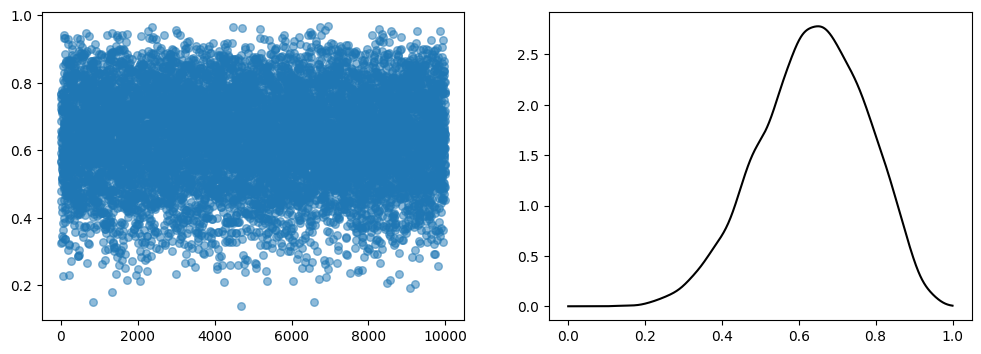

In [123]:
import random 
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

samples = random.choices(p_grid, weights =posterior, k = 10000)
kernel = gaussian_kde(samples,)


fig, axes = plt.subplots(1,2, figsize = (12,4))
axes[0].scatter(range(len(samples)), samples, s = 30, alpha=.5)
axes[1].plot(p_grid, kernel.pdf(p_grid), c = 'k')

fig.show()